In [26]:
from math import cos, sin, asin, pi
import math
import pandas as pd
import numpy as np
import re
import unidecode

from geonamescache import GeonamesCache
gc = GeonamesCache()

from scipy.spatial.distance import euclidean
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN

from mpl_toolkits.basemap import Basemap
import matplotlib.cm as cm

import matplotlib.pyplot as plt
% matplotlib inline 

UsageError: Line magic function `%` not found.


## Distance on Earth
arc-length is equal to the radius of the sphere multiplied by ⍺, the angle between points.  
Representing a point on the surface: The point arises as we rotate 40 degrees away from the horizontal (latitude), and 70 degrees away from the vertical (longitude). Hence, its spherical coordinates are (40, 70). ([lat, long])

In [70]:
def great_circle_distance(point_1,point_2):
    x1, y1 = tuple(point_1)
    x2, y2 = tuple(point_2)
    delta_x, delta_y = x2 - x1, y2 - y2
    haversin = sin(delta_x / 2) ** 2 + np.product([cos(x1), cos(x2), sin(delta_y / 2) ** 2])
    return 2 * asin(haversin ** 0.5)

In [12]:
distance = great_circle_distance(0, 0, pi, pi)
print(f"The distance equals {distance} units")

The distance equals 3.141592653589793 units


In [14]:
latitude_north, longitude_north = (90.0, 0)
latitude_south, longitude_south = (-90.0, 0)
to_radians =  np.radians([latitude_north, longitude_north,  # 1
                          latitude_south, longitude_south])

distance = great_circle_distance(*to_radians.tolist()) # 2
print(f"The unit-circle distance between poles equals {distance} units")

earth_distance = 3956 * distance # miles # 3
print(f"The distance between poles equals {earth_distance} miles")

The unit-circle distance between poles equals 3.141592653589793 units
The distance between poles equals 12428.14053760122 miles


In [114]:
def travel_distance(point_a, point_b):
    point_1 = map(math.radians, point_a)
    point_2 = map(math.radians, point_b)
    return 3956 * great_circle_distance(point_1, point_2)

assert travel_distance([90, 0], [-90, 0]) == earth_distance

def great_circle_distance_metric(point_a, point_b):
    R = 3958.8 # radius of earth in miles
    
    lat_a, lon_a = tuple(map(math.radians, point_a))
    lat_b, lon_b = tuple(map(math.radians, point_b))
    
    angle = math.sin(lat_a)*math.sin(lat_b) + math.cos(lat_a)*math.cos(lat_b)*math.cos(abs(lon_a - lon_b))
    if abs(angle) > 1: # solve the problem of angle > 1 and could not be passing to acos
        angle = 1
    angle = math.acos(angle)
    return R*angle

## 1. Re-cluster the world and US data separately.
This may require different clustering parameters for each dataset.

In [84]:
data = pd.read_csv(r'E:/Self-Dev/ManningProject-Headlines/data/hl3.csv',index_col = 0)

In [85]:
data_us = data.loc[data['countrycode'] == 'US'].copy()
data_world = data.loc[data['countrycode'] != 'US'].copy()
assert data_us.shape[0] + data_world.shape[0] == data.shape[0]

In [119]:
def plot_on_earth(df):
    map_plotter = Basemap()
    fig = plt.figure(figsize=(12, 8))
    n_groups = len(set(list(df['cluster'])))
    colors = cm.rainbow(np.linspace(0, 1, n_groups))
    for cluster_id, df_cluster in df.groupby('cluster'):
        map_plotter.scatter(df_cluster.longitude, df_cluster.latitude, latlon=True, label = cluster_id, \
                            color = colors[cluster_id] if cluster_id >= 0 else 'k') # will autoly use different colors
        #!!! color setting to avoid repeating colors and also point out the outliers
    map_plotter.shadedrelief()
    plt.legend()
    plt.show()

def plot_on_us(df):
    fig = plt.figure(figsize=(12, 8))
    map_lcc = Basemap(projection='lcc', lon_0=-95, llcrnrlon=-119,
                      llcrnrlat=22, urcrnrlon=-64, urcrnrlat=49, lat_1=33,
                      lat_2=45) 
    n_groups = len(set(list(df['cluster'])))
    colors = cm.rainbow(np.linspace(0, 1, n_groups))
    for cluster_id, df_cluster in df.groupby('cluster'):
        # print(cluster_id, df_cluster)
        map_lcc.scatter(list(df_cluster.longitude), list(df_cluster.latitude), latlon=True, label = cluster_id, \
                            color = colors[cluster_id] if cluster_id >= 0 else 'k')
    map_lcc.drawcoastlines()
    map_lcc.drawstates() # Draw States
    plt.legend()
    plt.show()

### US
Choose smaller parameters for US because it's more dense in locations.

In [116]:
# choose better parameters
x = np.linspace(100,250, 4)
y = [3,4,5,6]
x_1, y_1 = np.meshgrid(x, y) 
x_1 = x_1.reshape(1,-1)[0]
y_1 = y_1.reshape(1,-1)[0]
for eps,min_samples in list(zip(x_1,y_1)):
    cluster_model = DBSCAN(eps, min_samples, metric = great_circle_distance_metric)
    clusters =  cluster_model.fit_predict(data_us[['latitude','longitude']])
    print(eps, min_samples, len(set(clusters)),sum(np.array(clusters) == -1))

100.0 3 20 39
150.0 3 7 14
200.0 3 7 8
250.0 3 7 3
100.0 4 17 63
150.0 4 6 22
200.0 4 5 14
250.0 4 5 9
100.0 5 13 83
150.0 5 7 23
200.0 5 5 15
250.0 5 5 9
100.0 6 10 105
150.0 6 10 26
200.0 6 5 17
250.0 6 5 9


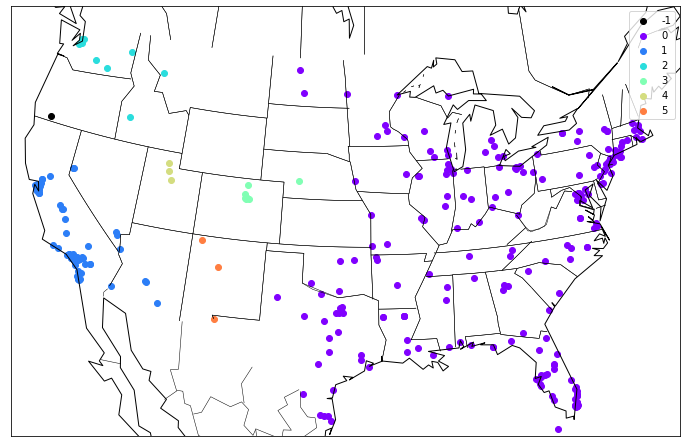

In [249]:
cluster_model = DBSCAN(eps = 250, min_samples = 3, metric = great_circle_distance_metric)
data_us['cluster'] = cluster_model.fit_predict(data_us[['latitude','longitude']]) # ?
plot_on_us(data_us)

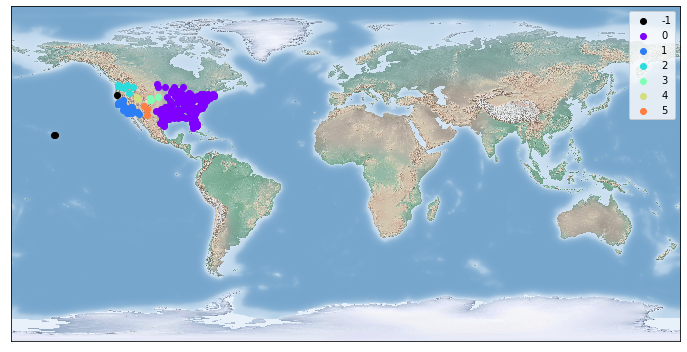

In [250]:
plot_on_earth(data_us)

### Worldwide

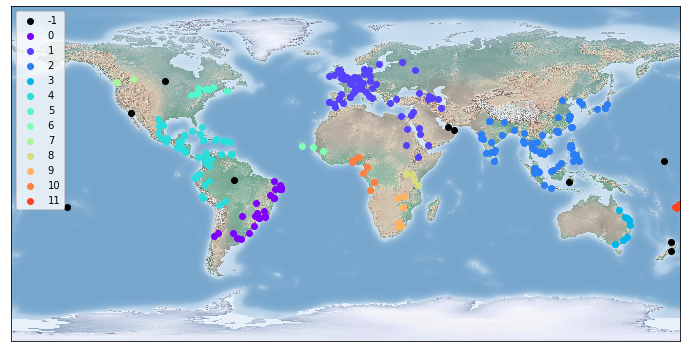

In [122]:
cluster_model = DBSCAN(eps = 650, min_samples = 3, metric = great_circle_distance_metric)
data_world['cluster'] = cluster_model.fit_predict(data_world[['latitude','longitude']]) # ?
plot_on_earth(data_world)

## 2. Sort the clusters by the number of headlines from largest to smallest.

In [251]:
idx_us = data_us.groupby('cluster').size().sort_values(ascending = False).index
data_us.groupby('cluster').size().sort_values(ascending = False)

cluster
 0    225
 1     58
 2      9
 3      8
 5      3
 4      3
-1      3
dtype: int64

In [143]:
idx_world = data_world.groupby('cluster').size().sort_values(ascending = False).index
data_world.groupby('cluster').size().sort_values(ascending = False)

cluster
 1     82
 2     81
 4     55
 0     28
 5     11
-1     10
 10     9
 3      9
 9      8
 8      6
 11     3
 7      3
 6      3
dtype: int64

## 3. Sort headlines
Sort headlines within each cluster by finding headlines closest to the center of the cluster. You can average the location coordinates in each cluster to get an approximation of the center. If you want to be more accurate, then you’ll need to apply a [geographic formula] to find the true geographic center of each cluster.  

We are making several assumptions in this section, such as using the average of geographic coordinates as the center of a cluster. Doing effective data science usually requires making some assumptions. These are acceptable as long as they are reasonable. If in doubt, ask a domain expert what to do in a situation. Sometimes we make an approximation to get an initial answer, and then refine our methods through iteration to increase accuracy.

In [241]:
# choose 4 clusters in each area (us/non-us)
def sort_to_center(df):
    lat_mean,long_mean = df.latitude.mean(), df.longitude.mean()
    df['distance'] = df[['latitude','longitude']].apply(lambda x: great_circle_distance_metric(x,(lat_mean,long_mean)),axis = 1)
    idx_order = np.argsort(df['distance'].values)
    df = df.iloc[idx_order,:].copy()
    return df

def sort_df(df, idx, n_groups):
    data = pd.DataFrame(columns = df.columns)
    for cluster_id in idx[:n_groups]:
        cluster = df.loc[df['cluster'] == cluster_id].copy()
        cluster_df = sort_to_center(cluster)
        data = data.append(cluster_df)
    return data

In [252]:
df_us = sort_df(data_us, idx_us, 4)
df_world = sort_df(data_world, idx_world, 4)

E:\PYTHON\Anaconda\envs\discovering-disease-outbreaks\lib\site-packages\pandas\core\frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


## 4. Record any repeated diseases & 5. Remove any irrelevant headlines
If no diseases appear to be repeating, try the clustering again. Also make sure to look at enough headlines within each cluster to find repeated diseases. If you find one or two major diseases, you can find all mentions of it in headlines using regular expressions.  
With limited resources, we need to prioritize our responses, therefore, we focus on the largest clusters. Once we have found a disease with numerous mentions, then we can search for clusters where the disease has a high prevalence.  
If a cluster contains a large percentage of a single disease, then it’s likely an indication of an epidemic. If there are multiple clusters of the disease around the world, then we have found a pandemic requiring immediate response. 


In [200]:
diseases = ['aids', 'bronchitis', 'cancer', 'chickenpox', 'chikungunya', 'chik fever', 'chlamydia', 'cholera', 'dengue', 'ebola', 'flu', 'gonorrhea', 'hepatitis A', 'hepatitis B', 'hepatitis C', 'hepatitis D', 'hepatitis E', 'herpes', 'hiv', 'influenza', 'mad cow', 'malaria', 'measles', 'meningitis', 'mumps', 'norovirus', 'pneumonia', 'Respiratory Syncytial Virus', 'rabies', 'rotavirus', 'rhinovirus', 'syphilis', 'tuberculosis', 'varicella', 'vericella', 'west nile', 'zika']
compile_disease = re.compile(r'|'.join(diseases), flags=re.IGNORECASE)

In [279]:
def find_epi(df, thres = 10, regexp = compile_disease):
    df['disease'] = df['headline'].apply(lambda x: re.search(regexp, x).group(0) if re.search(regexp, x) else None)
    data = pd.DataFrame(columns = df.columns)
    for idx in list(set(df['cluster'])):
        cluster = df[df['cluster'] == idx]
        count_disease = cluster.groupby('disease').size().sort_values(ascending = False)
        epi = list(count_disease.index[count_disease >= thres])
        if epi:
            print('In Group {}, we have epidemics:'.format(idx), ', '.join(epi))
            data = data.append(cluster.loc[[ix for ix in cluster.index if cluster['disease'][ix] in epi]])
        else:
            print('In Group {}, we do not have epidemics.'.format(idx))
    return data

In [280]:
df_us_pre = find_epi(df_us,6) # diseases repeating 6 times or above

In Group 0, we have epidemics: Zika, Dengue, Mumps, Hepatitis D, Rotavirus, West Nile, Measles, Rhinovirus, Norovirus, Chickenpox, Herpes
In Group 1, we have epidemics: Zika
In Group 2, we do not have epidemics.
In Group 3, we do not have epidemics.


In [281]:
df_us_pre

,city,cluster,country,countrycode,distance,headline,latitude,longitude,disease
357,Sevierville,0,United States,US,25.682442,Spike of Rhinovirus Cases in Sevierville,35.86815,-83.56184,Rhinovirus
334,Simpsonville,0,United States,US,132.514421,Chickenpox Hits Simpsonville,34.73706,-82.25428,Chickenpox
391,Alpharetta,0,United States,US,148.879360,West Nile Virus Exposure in Alpharetta,34.07538,-84.29409,West Nile
548,Lawrenceville,0,United States,US,154.774582,Lawrenceville is infested with Dengue,33.95621,-83.98796,Dengue
55,Nashville,0,United States,US,166.962256,Nashville takes precautions against Zika,36.16589,-86.78444,Zika
374,Huntington,0,United States,US,170.829059,Schools in Huntington Closed Due to Rotavirus ...,38.41925,-82.44515,Rotavirus
133,Charlotte,0,United States,US,178.258748,Zika cases concern Charlotte residents,35.22709,-80.84313,Zika
147,Louisville,0,United States,US,179.055826,West Nile Virus Outbreak in Louisville,38.25424,-85.75941,West Nile
153,Huntsville,0,United States,US,186.860585,Rumors about Rotavirus spreading in Huntsville...,34.73040,-86.58594,Rotavirus
129,Cincinnati,0,United States,US,206.727901,First Zika Case in Cincinnati,39.12711,-84.51439,Zika


In [282]:
df_world_pre = find_epi(df_world,6) # diseases repeating 6 times or above

In Group 0, we have epidemics: Zika
In Group 1, we have epidemics: Mad Cow, Flu, Rabies
In Group 2, we have epidemics: Zika
In Group 4, we have epidemics: Zika


In [284]:
df_world_pre

,city,cluster,country,countrycode,distance,headline,latitude,longitude,disease
459,Ribeirao Preto,0,NaN,BR,129.299194,More Zika patients reported in Ribeirao Preto,-21.17750,-47.81028,Zika
94,Belo Horizonte,0,Brazil,BR,167.697414,New Zika Case Confirmed in Belo Horizonte,-19.92083,-43.93778,Zika
44,Piracicaba,0,Brazil,BR,217.879557,"Zika outbreak in Piracicaba, Brazil",-22.72528,-47.64917,Zika
569,Botucatu,0,Brazil,BR,249.519245,More Zika patients reported in Botucatu,-22.88583,-48.44500,Zika
9,Sao Paulo,0,NaN,BR,262.139072,Zika Infested Monkeys in Sao Paulo,-23.54750,-46.63611,Zika
64,Brasilia,0,NaN,BR,290.089011,Second Zika Paitient in Brasilia,-15.77972,-47.92972,Zika
180,Santos,0,Brazil,BR,290.801584,Zika arrives in Santos,-23.96083,-46.33361,Zika
63,Rio de Janeiro,0,Brazil,BR,305.470745,Carnival under threat in Rio De Janeiro due to...,-22.90642,-43.18223,Zika
168,Niteroi,0,NaN,BR,307.930989,Zika Troubles come to Niteroi,-22.88333,-43.10361,Zika
621,Sao Jose,0,NaN,BR,607.718027,Zika Reported in Sao Jose,-28.21171,-49.16320,Zika
